In [1]:
import fcsparser as fcs
import os
import pandas as pd
import warnings
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.stats as stats

sns.set(style="white")
sns.set_context("notebook")
warnings.filterwarnings("once")

def gate_density (df, threshold, y_var='FSC-A', x_var='SSC-A'):
    
    ymin = df[y_var].min()
    ymax = df[y_var].max()
    xmin = df[x_var].min()
    xmax = df[x_var].max()
                                                                                                                                
    #Perform a kernel density estimate on the data:
    df_mini = df.sample(1000)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([df_mini[x_var], df_mini[y_var]])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    cut = Z.max()*threshold
    
    # threhold dataframe
    df['gate'] = kernel([df[x_var], df[y_var]])
    df2 = df[df.gate > cut]
    return df2

In [2]:
folders = ['/Users/weinberz/Box/Phosphoswitch/Flow/20200917 Triplicates/20200917 HEK293 8h 30h/',
           '/Users/weinberz/Box/Phosphoswitch/Flow/20200917 Triplicates/20200917 HEK293 54h 77h/',
           '/Users/weinberz/Box/Phosphoswitch/Flow/20200917 Triplicates/20200917 K562 8h 30h/',
           '/Users/weinberz/Box/Phosphoswitch/Flow/20200917 Triplicates/20200917 K562 54h 77h/']

In [3]:
dfs = []
for plate_num, folder in enumerate(folders):
    ffolderlist = [f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]
    
    df=pd.DataFrame()
    aa=1
        #load all fcs files
    for fdn in ffolderlist:
        ffilelist = os.listdir(folder+fdn)
        for fn in ffilelist:
            filename, file_ext = os.path.splitext(fn)
            if file_ext ==".fcs":
                path = folder + fdn + "//" + fn
                meta, df1 = fcs.parse(path, meta_data_only=False, reformat_meta=True)
                df1["WellName"]=fn.split("_")[3].split(".")[0]
                df1["WellNumber"]= aa
                df=df.append(df1)
                aa=aa+1

    # metadata file
    meta = folder+ "metadata.csv"
    df1=pd.read_csv(meta, names=['WellName','ID','Construct','Treatment','Timepoint','Replicate','Cell'])

    df=df1.merge(df, on=["WellName"])
    df['Plate'] = plate_num+1
    dfs.append(df)

In [4]:
df = pd.concat(dfs)
df = df[df["FSC-A"]>5E4]
df = df[df["SSC-A"]>2.5E4]

#remove NAs
df= df.loc[(df.select_dtypes(include=['number']) > 0).all(axis='columns'), :]
df=df.dropna()

df = df[['WellName','Plate', 'ID', 'Construct','Treatment','Timepoint', 'Replicate', 'Cell','FSC-A','SSC-H','SSC-A','FITC-A','PE-CF594-A']]

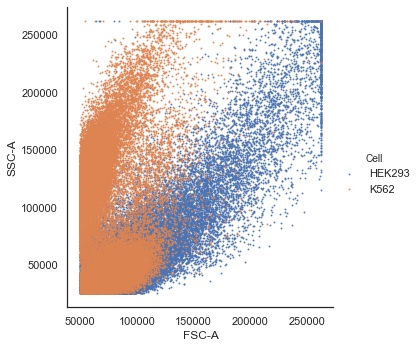

In [5]:
#Visualize populations for K562s and HEKs
sns.lmplot(y="SSC-A", x="FSC-A", data=df[(df["WellName"] == 'H01') &
                                         (df['Plate'].isin([0, 1, 2, 3]))], 
           hue='Cell', fit_reg=False, scatter_kws={'s': 1})
plt.show()

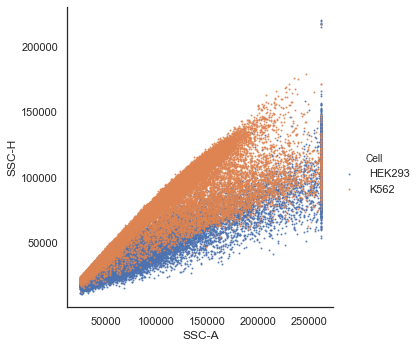

In [6]:
#Visualize populations for K562s and HEKs
sns.lmplot(y="SSC-H", x="SSC-A", data=df[(df["WellName"] == 'H01') &
                                         (df['Plate'].isin([0, 1, 2, 3]))], 
           hue='Cell', fit_reg=False, scatter_kws={'s': 1})
plt.show()

In [7]:
df2 = df.groupby(['Cell','Plate']).apply(gate_density, 0.1, x_var='SSC-A', y_var='SSC-H')

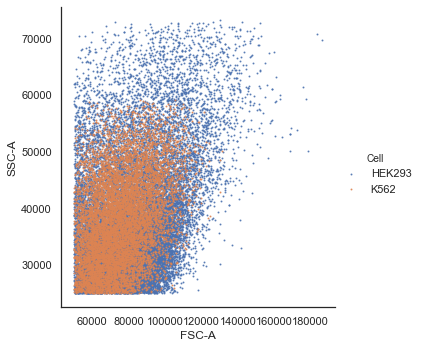

In [8]:
#Visualize populations for K562s and HEKs
sns.lmplot(y="SSC-A", x="FSC-A", data=df2[(df2["WellName"] == 'H01') &
                                         (df2['Plate'].isin([0, 1, 2, 3]))], 
           hue='Cell', fit_reg=False, scatter_kws={'s': 1})
plt.show()

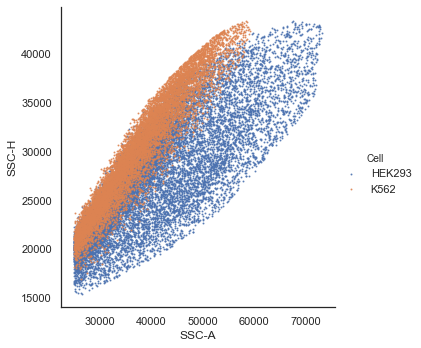

In [9]:
#Visualize populations for K562s and HEKs
sns.lmplot(y="SSC-H", x="SSC-A", data=df2[(df2["WellName"] == 'H01') &
                                         (df2['Plate'].isin([0, 1, 2, 3]))], 
           hue='Cell', fit_reg=False, scatter_kws={'s': 1})
plt.show()

In [10]:
#log data
for col in df2.columns:
    if df2[col].dtype=="float32":
        df2["log"+ col]=df2[col].apply(math.log10)

/usr/local/Caskroom/miniconda/base/envs/flow/lib/python3.6/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/usr/local/Caskroom/miniconda/base/envs/flow/lib/python3.6/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/usr/local/Caskroom/miniconda/base/envs/flow/lib/python3.6/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


Text(0.5, 8.959999999999994, 'log RFP')

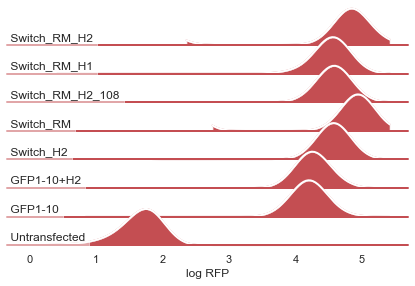

In [11]:
g = sns.FacetGrid(data=df2[(df2['Cell']=='K562') &
                           (df2['Treatment'] == 'Control')], col='Construct', sharey=False, aspect=12.5, height=.5, col_wrap=1)
g.map(sns.kdeplot, "logPE-CF594-A", shade=True, color='r', alpha=1, bw=0.2, clip_on=False, cut=0)
g.map(sns.kdeplot, "logPE-CF594-A", color="w", lw=2, bw=.2, clip_on=False, cut=0)
g.map(plt.axhline, y=0, lw=2, color='r', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

for ax in g.axes.flat:
    construct = ax.get_title().split("=")[1]
    ax.text(0,0.2, construct, ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    ax.set(facecolor=(0, 0, 0, 0))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("log RFP")

/usr/local/Caskroom/miniconda/base/envs/flow/lib/python3.6/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/usr/local/Caskroom/miniconda/base/envs/flow/lib/python3.6/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/usr/local/Caskroom/miniconda/base/envs/flow/lib/python3.6/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


Text(0.5, 8.959999999999994, 'log RFP')

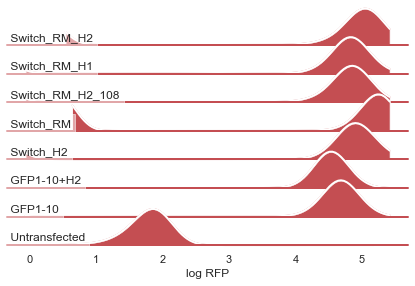

In [12]:
g = sns.FacetGrid(data=df2[(df2['Cell']=='HEK293') &
                           (df2['Treatment'] == 'Control')], col='Construct', sharey=False, aspect=12.5, height=.5, col_wrap=1)
g.map(sns.kdeplot, "logPE-CF594-A", shade=True, color='r', alpha=1, bw=0.2, clip_on=False, cut=0)
g.map(sns.kdeplot, "logPE-CF594-A", color="w", lw=2, bw=.2, clip_on=False, cut=0)
g.map(plt.axhline, y=0, lw=2, color='r', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

for ax in g.axes.flat:
    construct = ax.get_title().split("=")[1]
    ax.text(0,0.2, construct, ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    ax.set(facecolor=(0, 0, 0, 0))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("log RFP")

In [48]:
def calc_normalized_response(dataframe):
    control_mean = dataframe[dataframe['Treatment'] == 'Control']['response'].mean()
    dataframe['normResponse'] = dataframe['response'] / control_mean
    
    return dataframe

df_filt = df2[df2['logPE-CF594-A']>1].copy()

df_filt['response'] = df_filt['logFITC-A']/df_filt['logPE-CF594-A']
df_filt['normResponse'] = None
df_filt = df_filt.reset_index(drop=True).groupby(['Construct', 'Timepoint', 'Cell']).apply(calc_normalized_response)
df_filt['normResponse'] = df_filt['normResponse'].astype('float32')

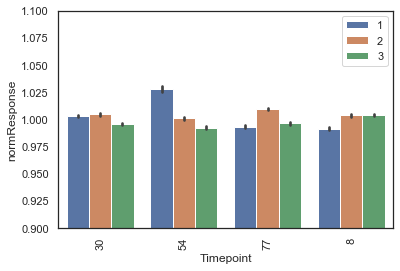

In [49]:
g = sns.barplot(data=df_filt[(df_filt['Treatment'] == 'Control') &
                             (df_filt['Construct'] == 'Switch_RM_H2') &
                             (df_filt['Cell'] == 'HEK293')], x="Timepoint", y="normResponse", hue="Replicate")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.legend(bbox_to_anchor=[1, 1])
plt.ylim([0.9, 1.1])
plt.show()

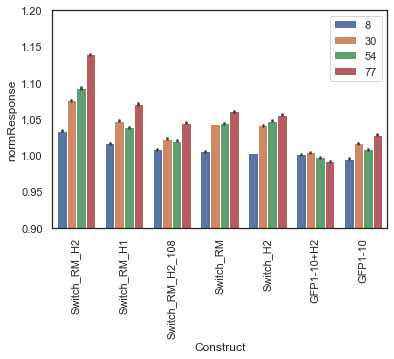

In [32]:
g = sns.barplot(data=df_filt[(~df_filt['Construct'].isin(['Untransfected'])) &
                             (df_filt['Treatment'] == 'FSK/IBMX') &
                             (df_filt['Cell'] == 'HEK293')], x="Construct", y="normResponse", hue="Timepoint",
               hue_order=['8','30','54', '77'])
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.ylim([0.9, 1.2])
plt.legend(bbox_to_anchor=[1, 1])
plt.show()

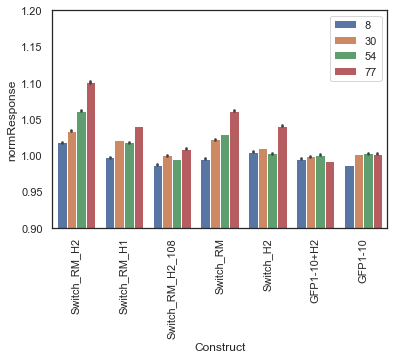

In [33]:
g = sns.barplot(data=df_filt[(~df_filt['Construct'].isin(['Untransfected'])) &
                             (df_filt['Treatment'] == 'FSK/IBMX') &
                             (df_filt['Cell'] == 'K562')], x="Construct", y="normResponse", hue="Timepoint",
               hue_order=['8','30','54', '77'])
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.ylim([0.9, 1.2])
plt.legend(bbox_to_anchor=[1, 1])
plt.show()

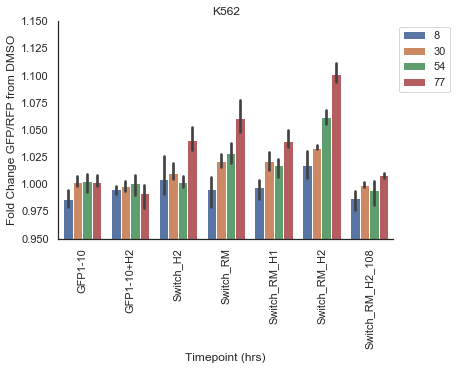

In [34]:
k562_summary = (df_filt[df_filt['Cell']=='K562']
 .groupby(['Construct','Treatment','Timepoint','Replicate'])['normResponse']
 .mean()
 .reset_index())

g = sns.barplot(data=k562_summary[(~k562_summary['Construct'].isin(['Untransfected'])) &
                             (k562_summary['Treatment'] == 'FSK/IBMX')], x="Construct", y="normResponse", hue="Timepoint",
               hue_order=['8','30','54', '77'])
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.ylim([0.95, 1.15])
plt.legend(bbox_to_anchor=[1, 1])
plt.xlabel('Timepoint (hrs)')
plt.ylabel('Fold Change GFP/RFP from DMSO')
sns.despine()
plt.title('K562')
plt.show()

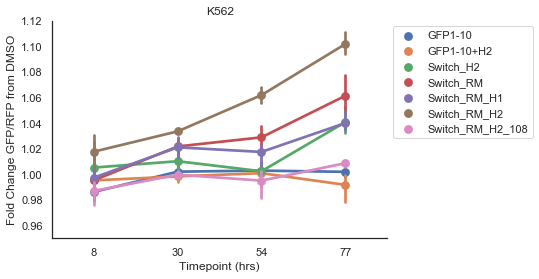

In [35]:
k562_summary = (df_filt[df_filt['Cell']=='K562']
 .groupby(['Construct','Treatment','Timepoint','Replicate'])['normResponse']
 .mean()
 .reset_index())

g = sns.pointplot(data=k562_summary[(~k562_summary['Construct'].isin(['Untransfected'])) &
                             (k562_summary['Treatment'] == 'FSK/IBMX')], x="Timepoint", y="normResponse", hue="Construct",
               order=['8','30','54', '77'])
#g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.ylim([0.95, 1.12])
plt.legend(bbox_to_anchor=[1, 1])
plt.xlabel('Timepoint (hrs)')
plt.ylabel('Fold Change GFP/RFP from DMSO')
sns.despine()
plt.title('K562')
plt.show()

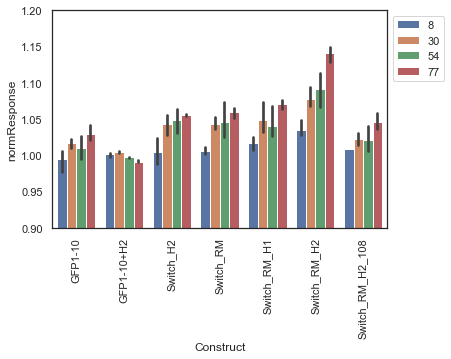

In [36]:
hek_summary = (df_filt[df_filt['Cell']=='HEK293']
 .groupby(['Construct','Treatment','Timepoint','Replicate'])['normResponse']
 .mean()
 .reset_index())

g = sns.barplot(data=hek_summary[(~hek_summary['Construct'].isin(['Untransfected'])) &
                             (hek_summary['Treatment'] == 'FSK/IBMX')], x="Construct", y="normResponse", hue="Timepoint",
               hue_order=['8','30','54', '77'])
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.ylim([0.9, 1.2])
plt.legend(bbox_to_anchor=[1, 1])
plt.show()

In [27]:
del df

In [56]:
summary = (df_filt
 .groupby(['Cell','Construct','Treatment','Timepoint','Replicate'])['normResponse']
 .mean()
 .unstack('Replicate'))
summary.to_csv('20200917_triplicate_normalize_response.csv')

In [57]:
summary = (df_filt
 .groupby(['Cell','Construct','Treatment','Timepoint','Replicate'])['logFITC-A']
 .mean()
 .unstack('Replicate'))
summary.to_csv('20200917_triplicate_gfp.csv')

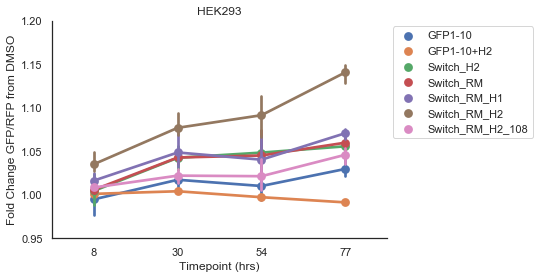

In [37]:
hek_summary = (df_filt[df_filt['Cell']=='HEK293']
 .groupby(['Construct','Treatment','Timepoint','Replicate'])['normResponse']
 .mean()
 .reset_index())

g = sns.pointplot(data=hek_summary[(~hek_summary['Construct'].isin(['Untransfected'])) &
                             (hek_summary['Treatment'] == 'FSK/IBMX')], x="Timepoint", y="normResponse", hue="Construct",
               order=['8','30','54', '77'])
#g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.ylim([0.95, 1.2])
plt.legend(bbox_to_anchor=[1, 1])
plt.xlabel('Timepoint (hrs)')
plt.ylabel('Fold Change GFP/RFP from DMSO')
sns.despine()
plt.title('HEK293')
plt.show()

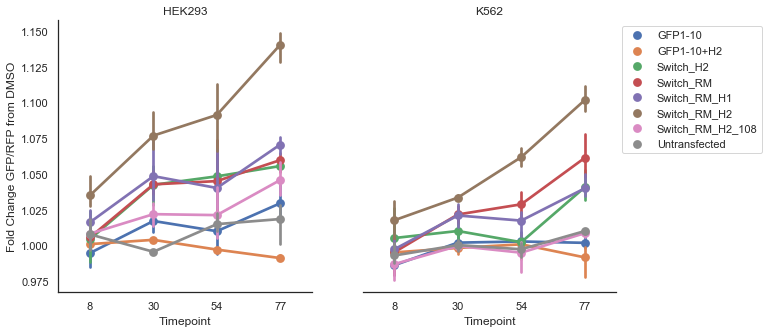

In [51]:
fig, axs = plt.subplots(1,2, sharey=True, figsize=(10,5))
for summary, ax in zip([hek_summary, k562_summary], axs):
    sns.pointplot(data=summary[(summary['Treatment'] == 'FSK/IBMX')], 
                  x="Timepoint", y="normResponse", hue="Construct",
                  order=['8','30','54', '77'], ax=ax)
axs[0].legend().set_visible(False)
axs[0].set_ylabel('Fold Change GFP/RFP from DMSO')
axs[0].set_title('HEK293')

axs[1].legend(bbox_to_anchor=[1, 1])
axs[1].set_ylabel('')
axs[1].set_title('K562')
sns.despine()
axs[1].spines['left'].set_visible(False)

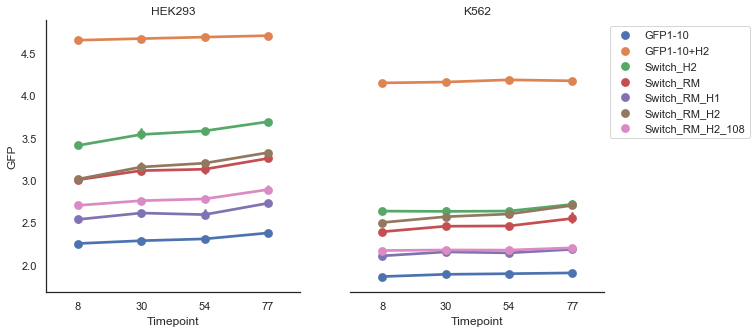

In [22]:
hek_summary = (df_filt[df_filt['Cell']=='HEK293']
 .groupby(['Construct','Treatment','Timepoint','Replicate'])['logFITC-A']
 .mean()
 .reset_index())

k562_summary = (df_filt[df_filt['Cell']=='K562']
 .groupby(['Construct','Treatment','Timepoint','Replicate'])['logFITC-A']
 .mean()
 .reset_index())

fig, axs = plt.subplots(1,2, sharey=True, figsize=(10,5))
for summary, ax in zip([hek_summary, k562_summary], axs):
    sns.pointplot(data=summary[(~summary['Construct'].isin(['Untransfected'])) &
                                   (summary['Treatment'] == 'FSK/IBMX')], 
                  x="Timepoint", y="logFITC-A", hue="Construct",
                  order=['8','30','54', '77'], ax=ax)
axs[0].legend().set_visible(False)
axs[0].set_ylabel('GFP')
axs[0].set_title('HEK293')

axs[1].legend(bbox_to_anchor=[1, 1])
axs[1].set_ylabel('')
axs[1].set_title('K562')
sns.despine()
axs[1].spines['left'].set_visible(False)